# Read data

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import optuna

In [2]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
y_train = pd.read_csv('data/y_train.csv')

print(X_train.shape, y_train.shape)
print(X_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


In [3]:
# Поменяем местами время и датчики 
X_train = X_train.swapaxes(1, 2)
X_test = X_test.swapaxes(1, 2)

In [4]:
print(X_train.shape, y_train.shape)
print(X_test.shape)

(323, 100, 40) (32300, 2)
(54, 100, 40)


In [4]:
# Преобразуем массивы в pd.DataFrame
lst_1 = []
for i in np.arange(X_train.shape[0]):
    lst_1.extend(X_train[i])
    
lst_2 = []
for i in np.arange(X_test.shape[0]):
    lst_2.extend(X_test[i])
    
X_train = pd.DataFrame(np.array(lst_1))
X_test = pd.DataFrame(np.array(lst_2))

In [105]:
X_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,1877.0,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0
1,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,1876.0,70.0,20.0,1170.0,132.0,28.0,1673.0,28.0,730.0,25.0


In [106]:
X_train.shape

(32300, 40)

In [107]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32300 entries, 0 to 32299
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       32300 non-null  float64
 1   1       32300 non-null  float64
 2   2       32300 non-null  float64
 3   3       32300 non-null  float64
 4   4       32300 non-null  float64
 5   5       32300 non-null  float64
 6   6       32300 non-null  float64
 7   7       32300 non-null  float64
 8   8       32300 non-null  float64
 9   9       32300 non-null  float64
 10  10      32300 non-null  float64
 11  11      32300 non-null  float64
 12  12      32300 non-null  float64
 13  13      32300 non-null  float64
 14  14      32300 non-null  float64
 15  15      32300 non-null  float64
 16  16      32300 non-null  float64
 17  17      32300 non-null  float64
 18  18      32300 non-null  float64
 19  19      32300 non-null  float64
 20  20      32300 non-null  float64
 21  21      32300 non-null  float64
 22

In [5]:
X_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,1877.0,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0
1,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,1876.0,70.0,20.0,1170.0,132.0,28.0,1673.0,28.0,730.0,25.0


In [6]:
# Добавим в тестовый сет данные о классах
df_train = X_train.join(y_train, how='left')
df_train['sample'] = df_train['sample-timestep'].apply(lambda x: x.split('-', 1)[0]).astype(int)
df_train['time'] = df_train['sample-timestep'].apply(lambda x: x.split('-', 1)[1]).astype(int)

In [7]:
df_train['class'] = df_train['class'].astype(int)

In [8]:
df_train.drop('sample-timestep', axis=1, inplace=True)

In [8]:
df_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,sample-timestep,class,sample,time
0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,129.0,29.0,1677.0,36.0,718.0,26.0,0-0,0,0,0
1,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,132.0,28.0,1673.0,28.0,730.0,25.0,0-1,0,0,1


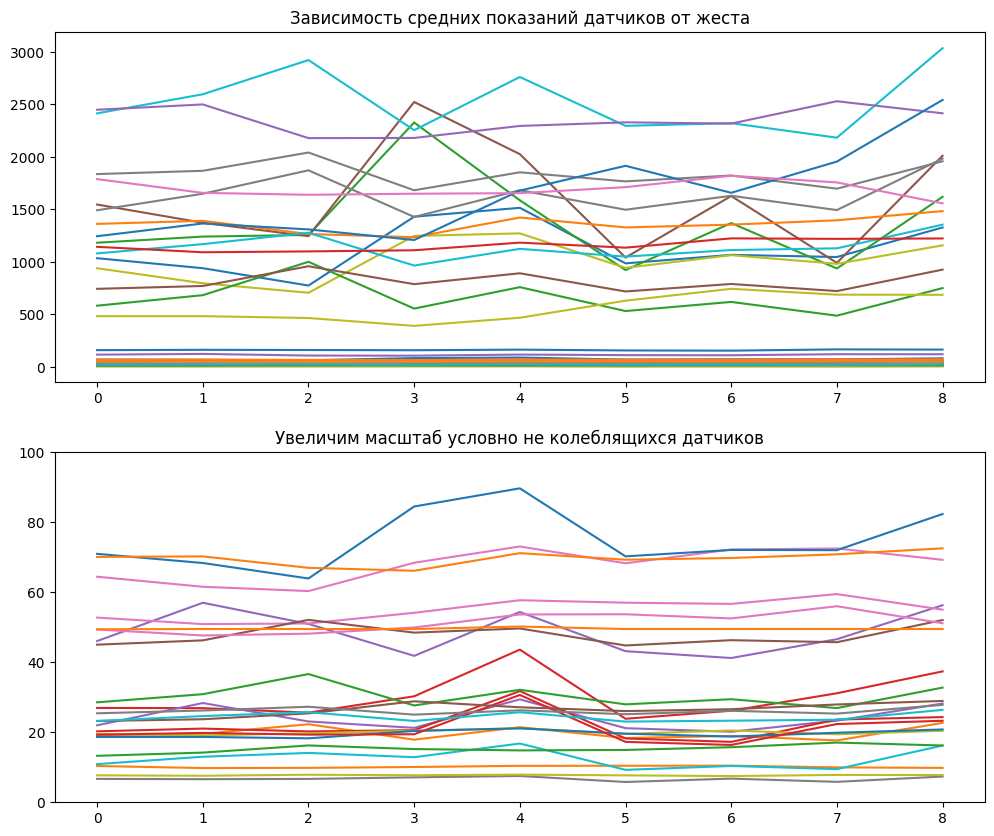

In [113]:
fig, axx = plt.subplots(2, 1, figsize=(12, 10))
axx[0].plot(df_train.groupby(by='class').mean())
axx[0].set_title('Зависимость средних показаний датчиков от жеста')

axx[1].plot(df_train.groupby('class').mean())
axx[1].set_title('Увеличим масштаб условно не колеблящихся датчиков')
axx[1].set_ylim(0,100);

Датчики, не работающие отсортирую и удалю

In [10]:
kill_sensor = []
for x in range(40):
    if df_train[x].mean() < 100:
        kill_sensor.append(x)

df_train.drop(kill_sensor, axis=1, inplace=True)

In [11]:
df_train.head(1)

,0,2,5,8,12,15,17,19,21,24,27,29,30,33,34,36,38,class,sample,time
0,1123.0,1450.0,1743.0,1068.0,652.0,783.0,1809.0,2142.0,1416.0,2669.0,1707.0,1192.0,1877.0,1169.0,129.0,1677.0,718.0,0,0,0


In [116]:
df_train.columns[:17]

Index([0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 34, 36, 38], dtype='object')

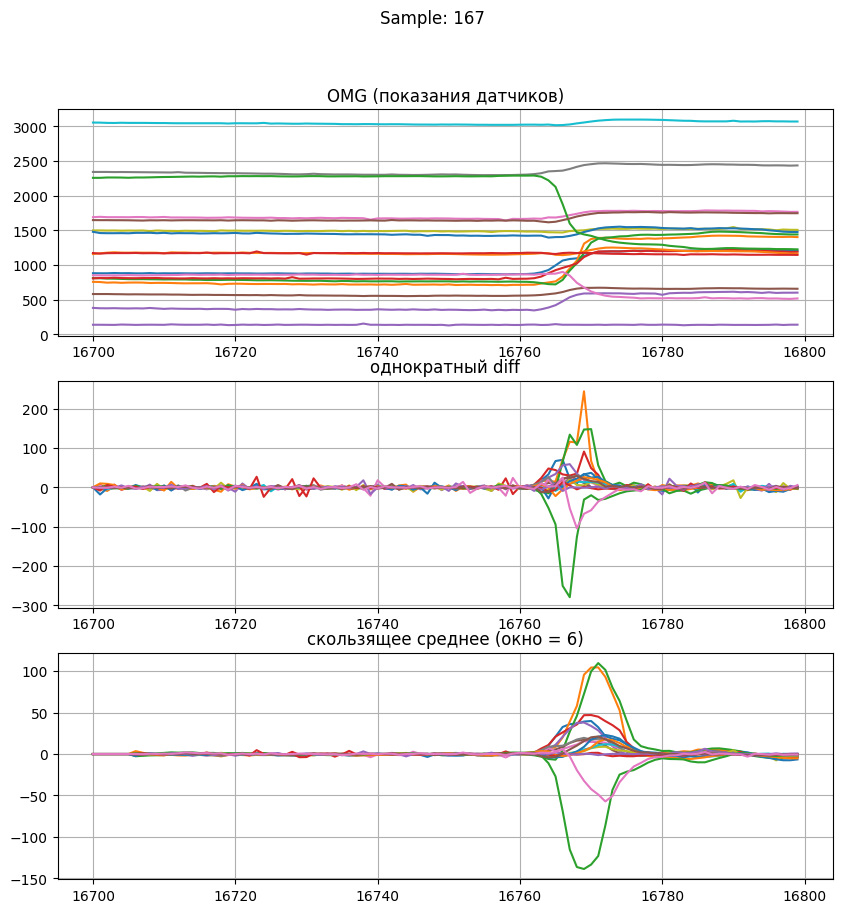

In [117]:
i = np.random.randint(323)
fig, axx = plt.subplots(nrows=3, figsize=(10, 10))
plt.suptitle(f'Sample: {i}')


axx[0].set_title('OMG (показания датчиков)')
axx[0].grid()
axx[0].plot(df_train[df_train.columns[:17]][df_train['sample'] == i])

axx[1].set_title('однократный diff')
axx[1].grid()
axx[1].plot(df_train[df_train.columns[:17]][df_train['sample'] == i].diff().fillna(0));

axx[2].set_title('скользящее среднее (окно = 6)')
axx[2].grid()
axx[2].plot(df_train[df_train.columns[:17]][df_train['sample'] == i].diff().rolling(6).mean().fillna(0));

In [12]:
# Добавим предикт sum
df_train['sum'] = df_train[df_train.columns[:17]].diff().rolling(4).mean().fillna(0).sum(axis=1).abs()

# Определим функцию сдвигающую class (жест) на время задержки
def shift_fixer(data_train, n=79):
    """_убиратель задержек_

    Args:
        n (int, optional): _граница начала жеста_. Менять в сторону уменьшения.
    """
    res = []
    for i in np.arange(data_train['sample'].max()+1):
        data = data_train[['sum', 'class', 'sample']][data_train['sample'] == i]
        curr_class = data['class'].iloc[0]
        for j in np.arange(100):
            if abs(data['sum'].iloc[j]) < n:
                res.append(curr_class)
            else:
                curr_class = data['class'].iloc[j]
                res.append(curr_class)
    return res
# Добавим исправленный class в данные
df_train['fixed_class'] = shift_fixer(df_train)

In [13]:
df_train.head(2)

,0,2,5,8,12,15,17,19,21,24,...,30,33,34,36,38,class,sample,time,sum,fixed_class
0,1123.0,1450.0,1743.0,1068.0,652.0,783.0,1809.0,2142.0,1416.0,2669.0,...,1877.0,1169.0,129.0,1677.0,718.0,0,0,0,0.0,0
1,1125.0,1441.0,1738.0,1064.0,647.0,788.0,1809.0,2146.0,1417.0,2671.0,...,1876.0,1170.0,132.0,1673.0,730.0,0,0,1,0.0,0


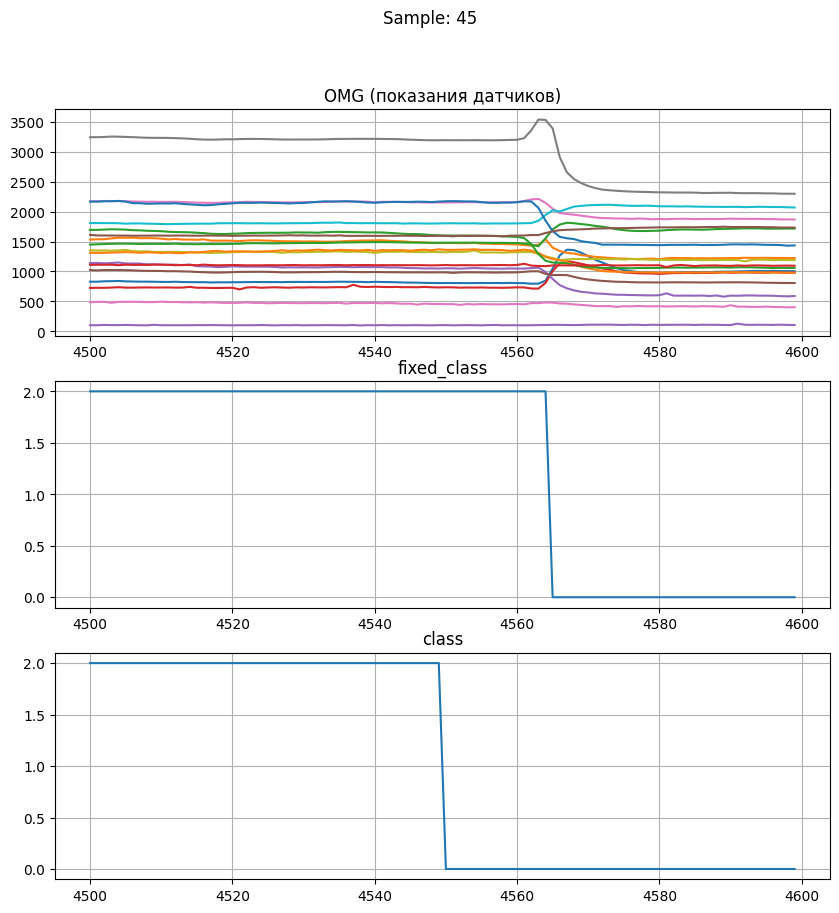

In [120]:
i = np.random.randint(323)
i = 45

fig, axx = plt.subplots(nrows=3, figsize=(10, 10))
plt.suptitle(f'Sample: {i}')

axx[0].set_title('OMG (показания датчиков)')
axx[0].grid()
axx[0].plot(df_train[df_train.columns[:17]][df_train['sample'] == i])

axx[1].set_title('fixed_class')
axx[1].grid()
axx[1].plot(df_train[['fixed_class']][df_train['sample'] == i]);

axx[2].set_title('class')
axx[2].grid()
axx[2].plot(df_train[['class']][df_train['sample'] == i]);

In [121]:
# Убедимся что по всем наблюдениям произошло смещение класса
unshifted = []
for i in np.arange(df_train['sample'].max()+1):
    dif = df_train['class'][df_train['sample'] == i].diff().sum() - df_train['fixed_class'][df_train['sample'] == i].diff().sum()
    if abs(dif) != 0: # значение получено экспериментально
        unshifted.append([i,dif])

(f'Необработанные наблюдения: {len(unshifted) != 0}')

'Необработанные наблюдения: False'

### 3. Подготовим данные к моделированию

In [122]:
df_train.columns[17:]

Index(['class', 'sample', 'time', 'sum', 'fixed_class'], dtype='object')

In [14]:
X = df_train.drop(df_train.columns[17:], axis=1)
y = df_train['fixed_class']
X_valid = X_test

# Выполним разбивку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25840, 17), (25840,), (6460, 17), (6460,))

In [53]:
X['fixed_class'] = y
X.to_csv('data/df_ready.csv', index=False)

In [60]:
%%time
# features = data.columns.difference(['target'])  # All columns except 'stories'
# target = 'target'

# # Convert categorical features to strings
# categorical_features = data[features].select_dtypes(include=['object']).columns
# for feature in categorical_features:
#     data[feature] = data[feature].astype(str)

# X = data[features]
# y = data[target]
# # Разделим выборку на тренировочную и тестовую
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42)

# # Создание списка номеров признаков с типом объект
# categorical_features_indices = np.where(X_train.dtypes == 'object')[0]

# Create CatBoost pools for training and testing
train_pool = Pool(data=X_train, label=y_train) #, cat_features = categorical_features_indices)
test_pool = Pool(data=X_test, label=y_test) #, cat_features = categorical_features_indices)

# Train the CatBoost model
model = CatBoostClassifier(iterations=100, depth=11, learning_rate=0.1, loss_function='MultiClass', nan_mode='Min', verbose=100, task_type="GPU",
                           devices='0')
model.fit(train_pool)
metrica_catboost_with_zero = f1_score(y_test, model.predict(test_pool), average='micro')
print('Метрика f1: \033[3m\033[33m{}\033[0m'.format({metrica_catboost_with_zero}))

0:	learn: 1.5946990	total: 161ms	remaining: 16s
99:	learn: 0.0463222	total: 13.3s	remaining: 0us
Метрика f1: {0.9826625386996904}
CPU times: user 20.3 s, sys: 3.92 s, total: 24.2 s
Wall time: 15.3 s


In [66]:
%%time

sample_sub = model.predict(X_valid)

CPU times: user 15.7 ms, sys: 5.4 ms, total: 21.1 ms
Wall time: 10.3 ms


In [63]:
sample_submission = pd.read_csv('data/sample_submission.csv')

In [67]:

sample_submission

,sample-timestep,class
0,323-0,0
1,323-1,7
2,323-2,3
3,323-3,0
4,323-4,5
...,...,...
5395,376-95,3
5396,376-96,1
5397,376-97,0
5398,376-98,5


In [71]:
sample_submission['class'] = sample_sub
sample_submission['class'].value_counts()

class
0    3389
6     303
7     276
3     266
8     260
2     257
5     251
4     206
1     192
Name: count, dtype: int64

In [124]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25840, 17), (25840,), (6460, 17), (6460,))

In [125]:
train_pool = Pool(data=X_train, label=y_train) #, cat_features = categorical_features_indices)
test_pool = Pool(data=X_test, label=y_test) #, cat_features = categorical_features_indices)

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 300, 25),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 8, 12),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)
    }

    model = CatBoostClassifier(**params, verbose=500, task_type="GPU", devices='0')
    model.fit(train_pool)
    f1 = f1_score(y_test, model.predict(test_pool), average='micro')

    return f1

In [126]:
%%time
study = optuna.create_study(study_name="CatBoostClassifier", direction='maximize')
study.optimize(objective, n_trials=2)
print('Best hyperparameters:', study.best_params)
print(f'Best F1:, \033[3m\033[33m{study.best_value}\033[0m')

[I 2024-08-07 18:00:31,507] A new study created in memory with name: CatBoostClassifier
/tmp/ipykernel_17804/4008092183.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "iterations": trial.suggest_int("iterations", 200, 300, 25),


0:	learn: 1.9436120	total: 95.6ms	remaining: 26.2s
274:	learn: 0.0474480	total: 21.2s	remaining: 0us


[I 2024-08-07 18:00:54,532] Trial 0 finished with value: 0.9821981424148607 and parameters: {'iterations': 275, 'learning_rate': 0.04048459041022145, 'depth': 10, 'min_data_in_leaf': 62}. Best is trial 0 with value: 0.9821981424148607.
/tmp/ipykernel_17804/4008092183.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "iterations": trial.suggest_int("iterations", 200, 300, 25),


0:	learn: 2.1838689	total: 145ms	remaining: 39.7s
274:	learn: 0.8353120	total: 39.2s	remaining: 0us


[I 2024-08-07 18:01:35,130] Trial 1 finished with value: 0.9681114551083592 and parameters: {'iterations': 275, 'learning_rate': 0.002094684765852858, 'depth': 11, 'min_data_in_leaf': 69}. Best is trial 0 with value: 0.9821981424148607.


Best hyperparameters: {'iterations': 275, 'learning_rate': 0.04048459041022145, 'depth': 10, 'min_data_in_leaf': 62}
Best F1:, 0.9821981424148607
CPU times: user 1min 29s, sys: 18.9 s, total: 1min 48s
Wall time: 1min 3s


In [130]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'iterations': 275, 'learning_rate': 0.04048459041022145, 'depth': 10, 'min_data_in_leaf': 62}
f1_score на обучающем наборе: 0.98


### На данных обучаю нейронную сеть для сравнения

In [18]:
import tensorflow as tf
print("TF", tf.__version__)
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML, display_html
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output, display_html, HTML
import contextlib
import time
import io
import urllib
import base64
import keras
from keras import backend as K
from keras import optimizers, Sequential
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

2024-08-10 12:17:12.184724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 12:17:13.744182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TF 2.16.1


In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape

((25840, 17), (25840,), (6460, 17), (6460,), (5400, 40))

In [27]:
#  Преобразование в np.array
X_train_n = np.array(X_train)
X_test_n = np.array(X_test)
y_train_n = np.vstack(y_train)
y_test_n = np.vstack(y_test)
X_valid_n = np.array(X_valid)

In [19]:
# Задаю количество классов
NUM_CLASSES = 9

# нормализуем входы
x_train2 = X_train_n.astype('float32') / 255 - 0.5
x_test2 = X_test_n.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train_n, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test_n, NUM_CLASSES)

In [21]:
K.clear_session()

model = Sequential()

model.add(L.Dense(64, activation='relu', input_dim=17))

model.add(L.Dropout(0.25))

model.add(L.Dense(64, activation='relu'))

model.add(L.Dropout(0.25))

model.add(L.Dense(32, activation='relu'))

model.add(L.Dropout(0.25))

model.add(L.Dense(9, activation='softmax'))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',

              optimizer='adam',

              metrics=['accuracy'])

history = model.fit(x_train2, y_train2,
        validation_split=0.25,
        epochs=30,
        batch_size=64,
        verbose=1)

score = model.evaluate(x_test2, y_test2, batch_size=64)

Epoch 1/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4955 - loss: 1.8276 - val_accuracy: 0.8186 - val_loss: 0.4788
Epoch 2/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7854 - loss: 0.6299 - val_accuracy: 0.8856 - val_loss: 0.3441
Epoch 3/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8398 - loss: 0.4780 - val_accuracy: 0.9141 - val_loss: 0.2871
Epoch 4/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8692 - loss: 0.4090 - val_accuracy: 0.9402 - val_loss: 0.2497
Epoch 5/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8839 - loss: 0.3754 - val_accuracy: 0.9406 - val_loss: 0.2385
Epoch 6/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8948 - loss: 0.3425 - val_accuracy: 0.9455 - val_loss: 0.2102
Epoch 7/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9061 - loss: 0.3102 - val_accuracy: 0.9409 - val_loss: 0.1994
Epoch 8/30
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9126 - loss: 0.3063 - val_accuracy: 0.

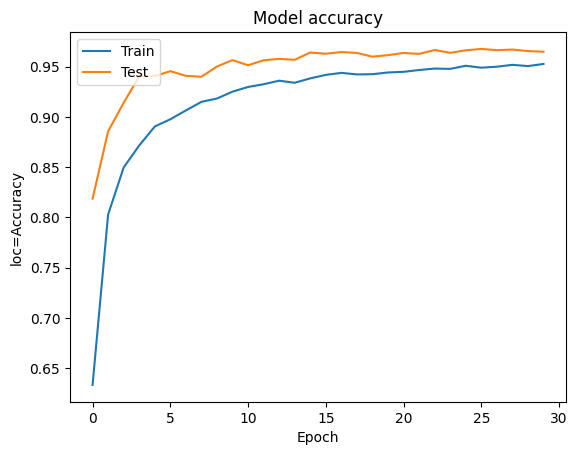

In [23]:
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')

plt.ylabel('loc=Accuracy')

plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [72]:
score

[0.121737539768219, 0.9648606777191162]

In [35]:
# предсказываем классы: определяем номер класса, для которого вероятность принадлежности максимальна
sample_sub =  np.argmax(model.predict(X_train_n), axis = 1)

808/808 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step


Чтобы в итоге сделать предсказание на модели обученной нейронкой, в модель надо подавать np.array массив того же размера на котором обучалась модель

In [36]:
sample_sub

array([1, 0, 0, ..., 0, 0, 0])

In [70]:
X_valid_n.reshape(27000, -1)

array([[1681.,    4., 1834., ..., 2254.,   43.,    0.],
       [1376.,   27.,   94., ...,   20.,   46.,  843.],
       [  25., 1927.,   21., ..., 1368.,   41.,   10.],
       ...,
       [  49., 1877.,   25., ..., 1320.,   35.,   17.],
       [1952.,   52.,   40., ..., 1103., 1694.,   71.],
       [  12., 1171.,  123., ...,   26.,  316.,   28.]])

In [41]:
X_train_n.shape

(25840, 17)

In [71]:
model.predict(X_valid_n)

2024-08-10 13:23:49.801638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [32,40], In[1]: [17,64]
	 [[{{node sequential_1/dense_1/MatMul}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_1/MatMul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_31276/2958509887.py", line 1, in <module>

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 504, in predict

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 204, in one_step_on_data_distributed

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 194, in one_step_on_data

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 92, in predict_step

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/models/sequential.py", line 209, in call

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/models/functional.py", line 202, in call

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/models/functional.py", line 592, in call

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/layers/core/dense.py", line 150, in call

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 3440, in matmul

  File "/home/wizardol/miniconda3/envs/test/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 475, in matmul

Matrix size-incompatible: In[0]: [32,40], In[1]: [17,64]
	 [[{{node sequential_1/dense_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_68416]